In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc


In [2]:
roll_digit = 5

In [3]:

# 1. Implement Encoder and Decoder Networks
class AutoEncoder(nn.Module):
    def __init__(self, bottleneck_dim=64 ):  
        ''' or may bottleneck be 32 ?'''
        super(AutoEncoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, bottleneck_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid() # maybe do not uncomment this line
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [4]:

# Load MNIST dataset
def load_data(normal_digit=roll_digit):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    # Filter training data for normal digit only
    train_idx = train_dataset.targets == normal_digit
    train_dataset.data = train_dataset.data[train_idx]
    train_dataset.targets = train_dataset.targets[train_idx]
    
    return torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True), \
           torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False), \
           test_dataset


In [5]:

# Training function
def train_model(model, train_loader, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        for data, _ in train_loader:
            data = data.view(-1, 784)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')


In [6]:

# Load data 
train_loader, test_loader, test_dataset = load_data(normal_digit=roll_digit)


In [7]:

# 2. Train the model
model = AutoEncoder(bottleneck_dim=16)
train_model(model, train_loader)


Epoch 1/100, Loss: 0.7429
Epoch 2/100, Loss: 0.7833
Epoch 3/100, Loss: 0.7460
Epoch 4/100, Loss: 0.7654
Epoch 5/100, Loss: 0.7761
Epoch 6/100, Loss: 0.7900
Epoch 7/100, Loss: 0.7550
Epoch 8/100, Loss: 0.7967
Epoch 9/100, Loss: 0.7705
Epoch 10/100, Loss: 0.7559
Epoch 11/100, Loss: 0.7427
Epoch 12/100, Loss: 0.7642
Epoch 13/100, Loss: 0.7714
Epoch 14/100, Loss: 0.7610
Epoch 15/100, Loss: 0.7653
Epoch 16/100, Loss: 0.7552
Epoch 17/100, Loss: 0.7439
Epoch 18/100, Loss: 0.7861
Epoch 19/100, Loss: 0.7552
Epoch 20/100, Loss: 0.8029
Epoch 21/100, Loss: 0.7402
Epoch 22/100, Loss: 0.7829
Epoch 23/100, Loss: 0.7577
Epoch 24/100, Loss: 0.7803
Epoch 25/100, Loss: 0.8059
Epoch 26/100, Loss: 0.7668
Epoch 27/100, Loss: 0.8165
Epoch 28/100, Loss: 0.8056
Epoch 29/100, Loss: 0.8009
Epoch 30/100, Loss: 0.7872
Epoch 31/100, Loss: 0.7415
Epoch 32/100, Loss: 0.8210
Epoch 33/100, Loss: 0.7666
Epoch 34/100, Loss: 0.7959
Epoch 35/100, Loss: 0.7671
Epoch 36/100, Loss: 0.7870
Epoch 37/100, Loss: 0.7236
Epoch 38/1

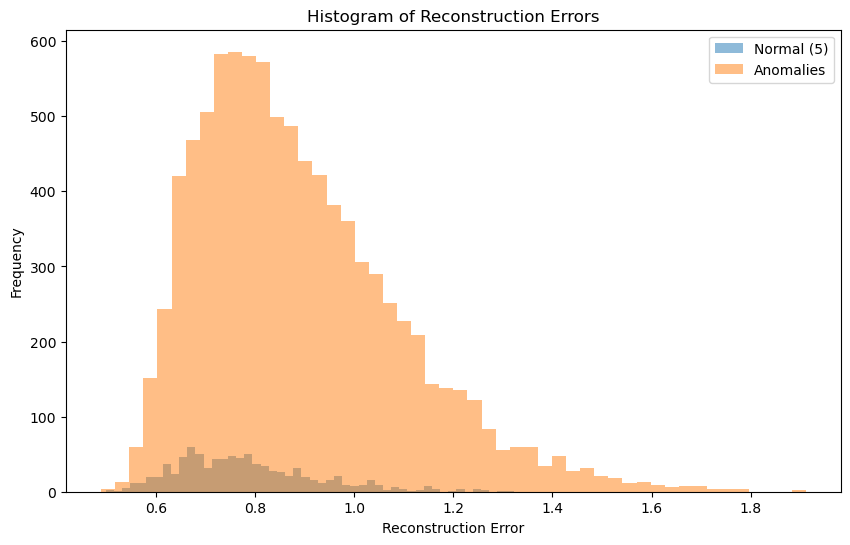

In [8]:

# 3. Compute reconstruction errors
model.eval()
normal_errors = []
anomaly_errors = []
true_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.view(-1, 784)
        outputs = model(data)
        mse = ((outputs - data) ** 2).mean(dim=1)
        
        for i in range(len(labels)):
            if labels[i] == roll_digit:  # Normal digit
                normal_errors.append(mse[i].item())
                true_labels.append(0)
            else:  # Anomaly
                anomaly_errors.append(mse[i].item())
                true_labels.append(1)

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(normal_errors, bins=50, alpha=0.5, label=f'Normal ({roll_digit})')
plt.hist(anomaly_errors, bins=50, alpha=0.5, label='Anomalies')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Reconstruction Errors')
plt.show()


In [9]:

# 4. Choose threshold (using 95th percentile of normal errors)
threshold = np.percentile(normal_errors, 95)
print(f"Chosen threshold: {threshold}")


Chosen threshold: 1.0384092628955839


In [10]:

# 5. Evaluate performance
predictions = [1 if e > threshold else 0 for e in normal_errors + anomaly_errors]
true_labels = [0] * len(normal_errors) + [1] * len(anomaly_errors)

precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Precision: 0.9774
Recall: 0.2133
F1-score: 0.3502


### 6. Hyperparameter Tuning with different bottleneck dimensions

Epoch 1/100, Loss: 0.7500
Epoch 2/100, Loss: 0.7893
Epoch 3/100, Loss: 0.7986
Epoch 4/100, Loss: 0.7706
Epoch 5/100, Loss: 0.7686
Epoch 6/100, Loss: 0.7985
Epoch 7/100, Loss: 0.8023
Epoch 8/100, Loss: 0.7661
Epoch 9/100, Loss: 0.7722
Epoch 10/100, Loss: 0.7726
Epoch 11/100, Loss: 0.7725
Epoch 12/100, Loss: 0.7525
Epoch 13/100, Loss: 0.7683
Epoch 14/100, Loss: 0.7423
Epoch 15/100, Loss: 0.7256
Epoch 16/100, Loss: 0.7686
Epoch 17/100, Loss: 0.7631
Epoch 18/100, Loss: 0.7629
Epoch 19/100, Loss: 0.7848
Epoch 20/100, Loss: 0.7952
Epoch 21/100, Loss: 0.7308
Epoch 22/100, Loss: 0.7763
Epoch 23/100, Loss: 0.7745
Epoch 24/100, Loss: 0.7288
Epoch 25/100, Loss: 0.7448
Epoch 26/100, Loss: 0.7916
Epoch 27/100, Loss: 0.7541
Epoch 28/100, Loss: 0.7852
Epoch 29/100, Loss: 0.7620
Epoch 30/100, Loss: 0.7551
Epoch 31/100, Loss: 0.7406
Epoch 32/100, Loss: 0.7691
Epoch 33/100, Loss: 0.7525
Epoch 34/100, Loss: 0.7885
Epoch 35/100, Loss: 0.7557
Epoch 36/100, Loss: 0.7462
Epoch 37/100, Loss: 0.7734
Epoch 38/1

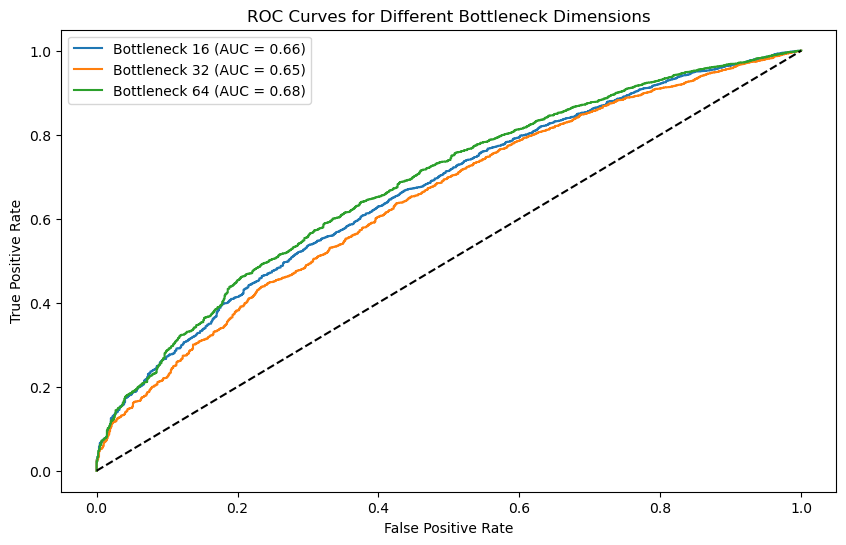

In [11]:


bottleneck_dims = [16, 32, 64]
plt.figure(figsize=(10, 6))

for dim in bottleneck_dims:
    model = AutoEncoder(bottleneck_dim=dim)
    train_model(model, train_loader)
    model.eval()
    
    errors = []
    labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data = data.view(-1, 784)
            outputs = model(data)
            mse = ((outputs - data) ** 2).mean(dim=1)
            errors.extend(mse.tolist())
            labels.extend([0 if l == roll_digit else 1 for l in label])
    
    fpr, tpr, _ = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'Bottleneck {dim} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Bottleneck Dimensions')
plt.legend()
plt.show()
